# CityLearn REINFORCE agent
Name: Shota Takeshima

## Installation: CityLearn

* Temporally, I put CityLearn codes in my private git repository to test it. 
* After some progress is confirmed, I'll push the modified code to our team repository.

In [ ]:
!rm -rf ./CityLearn_garage/
!git clone https://github.com/shttksm/CityLearn_garage.git

Cloning into 'CityLearn_garage'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 122 (delta 27), reused 111 (delta 19), pack-reused 0
Receiving objects: 100% (122/122), 11.92 MiB | 20.14 MiB/s, done.
Resolving deltas: 100% (27/27), done.


## Confirm the baseline multiple agent, RL_Agents_Coord
* RL_Agents_Coord is in `CityLearn_garage/agent.py`. Each building has itw own SAC agent and this class manages such SAC agents.

In [ ]:
!grep RL_Agents_Coord CityLearn_garage/agent.py

class RL_Agents_Coord:


### Simulation environment

In [ ]:
# Loading libraries
import sys
sys.path.append("./CityLearn_garage")

from citylearn import CityLearn
from reward_function import reward_function_ma
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from agent import RL_Agents_Coord

import os
import gym
import numpy as np
#from stable_baselines3 import SAC
#from stable_baselines3.sac.policies import MlpPolicy as MlpPolicy_SAC
#from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
from pathlib import Path
import time

import pandas as pd
import seaborn as sns

import pickle
import copy

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def get_env(climate_zone):
  # Load environment
  data_path = Path("./CityLearn_garage/data/Climate_Zone_"+str(climate_zone))
  building_attributes = data_path / 'building_attributes.json'
  weather_file = data_path / 'weather_data.csv'
  solar_profile = data_path / 'solar_generation_1kW.csv'
  building_state_actions = './CityLearn_garage/buildings_state_action_space.json'
  # building_ids = ["Building_1","Building_2","Building_3","Building_4","Building_5","Building_6","Building_7","Building_8","Building_9"]
  building_ids = ["Building_1"] # Changed here. From 9 buildings to single building
  objective_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption']

  # Contain the lower and upper bounds of the states and actions, to be provided to the agent to normalize the variables between 0 and 1.
  # Can be obtained using observations_spaces[i].low or .high
  env = CityLearn(data_path, 
                  building_attributes, 
                  weather_file, 
                  solar_profile, 
                  building_ids, 
                  buildings_states_actions = building_state_actions, 
                  cost_function = objective_function, 
                  verbose = 1, 
                  simulation_period=(0,8760-1), 
                  central_agent=False)
  # Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
  building_info = env.get_building_information()  
  observations_spaces, actions_spaces = env.get_state_action_spaces()

  return env, building_ids, building_state_actions, building_info, observations_spaces, actions_spaces

In [ ]:
env, building_ids, building_state_actions, building_info, observations_spaces, actions_spaces = get_env(2)

In [ ]:
observations_spaces

[Box(-9.600000381469727, 1090.7900390625, (26,), float32)]

In [ ]:
actions_spaces

[Box(-0.5, 0.5, (2,), float32)]

### Train a instance of RI_Agents_Coord
* First in first, I confirm wether the original multiple agents works correctly.

In [ ]:
# Hyperparameters
bs = 256
tau = 0.005
gamma = 0.99
lr = 0.0003
hid = [256,256]

n_episodes = 12

In [ ]:
# Instantiating the control agent(s)
agents = RL_Agents_Coord(building_ids, 
                         building_state_actions, 
                         building_info, 
                         observations_spaces, 
                         actions_spaces, 
                         discount = gamma, 
                         batch_size = bs, 
                         replay_buffer_capacity = 1e5, 
                         regression_buffer_capacity = 12*8760, 
                         tau=tau, 
                         lr=lr, 
                         hidden_dim=hid, 
                         start_training=8760*3, 
                         exploration_period = 8760*3+1,  
                         start_regression=8760, 
                         information_sharing = False, 
                         pca_compression = .95, 
                         action_scaling_coef=0.5, 
                         reward_scaling = 5., 
                         update_per_step = 1, 
                         iterations_as = 2)

**You can skip here**. This cord just confirming the original agents.

In [ ]:
cost_by_epoch = []
action_hist = []
# The number of episodes can be replaces by a stopping criterion (i.e. convergence of the average reward)
start = time.time()
for e in range(n_episodes): 
    is_evaluating = (e > 7) # Evaluate deterministic policy after 7 epochs
    rewards = []
    state = env.reset()
    done = False

    j = 0
    action, coordination_vars = agents.select_action(state, deterministic=is_evaluating)   
    action_hist.append(action) 
    while not done:
        next_state, reward, done, _ = env.step(action)
        action_next, coordination_vars_next = agents.select_action(next_state, deterministic=is_evaluating)
        agents.add_to_buffer(state, action, reward, next_state, done, coordination_vars, coordination_vars_next)
        action_hist.append(action_next)
        state = next_state
        coordination_vars = coordination_vars_next
        action = action_next

    cost = env.cost()
    cost_by_epoch.append(cost)
    print('Loss -', cost, 'Simulation time (min) -',(time.time()-start)/60.0)

Cumulated reward: -1673868760.8193188
Cost score: {'ramping': 1.776153, '1-load_factor': 1.0796991562924123, 'average_daily_peak': 1.2237937, 'peak_demand': 1.1520804, 'net_electricity_consumption': 1.0314388, 'total': 1.2526330227868028}
Loss - {'ramping': 1.776153, '1-load_factor': 1.0796991562924123, 'average_daily_peak': 1.2237937, 'peak_demand': 1.1520804, 'net_electricity_consumption': 1.0314388, 'total': 1.2526330227868028} Simulation time (min) - 0.05038893620173136
Cumulated reward: -1659484464.4957087
Cost score: {'ramping': 1.7695692, '1-load_factor': 1.0830602986784124, 'average_daily_peak': 1.2179848, 'peak_demand': 1.155436, 'net_electricity_consumption': 1.0302082, 'total': 1.2512517043584852}
Loss - {'ramping': 1.7695692, '1-load_factor': 1.0830602986784124, 'average_daily_peak': 1.2179848, 'peak_demand': 1.155436, 'net_electricity_consumption': 1.0302082, 'total': 1.2512517043584852} Simulation time (min) - 0.12334486643473307
Cumulated reward: -1660307432.0092876
Cost

KeyboardInterrupt: ignored

In [ ]:
pd.DataFrame(map(lambda x: x[0], action_hist), columns=["cooling_storage", "dhw_storage"])[-8760:-1]["cooling_storage"].plot()

In [ ]:
ax = pd.DataFrame(cost_by_epoch)[["total"]].plot()
cz = env.data_path.name
bids = env.building_ids
plt.title(f"Training Curve of SAC multiple-agents (but using only one building)\n {cz}:{bids}")
plt.xlabel("Epoch (1year = 8760hours:timesteps)")
plt.ylabel("Total Cost")
pass

## Create the baseline RI_ActorCritic_Coord


In [ ]:
import os
import torch.optim as optim
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.distributions import Normal
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn.utils as utils
import numpy as np
import random
import copy
import gym
from sklearn.linear_model import LinearRegression
import json
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
# torch.autograd.set_detect_anomaly(True)
import time
import math

# set the path so that we could read created modules
import sys

# organized into different classes for editing easier
from RBC_Agent import RBC_Agent
from model import PolicyNetwork, SoftQNetwork, RegressionBuffer
from ReplayBuffer import ReplayBuffer
from data_process import no_normalization, periodic_normalization, onehot_encoding, normalize, remove_feature

# check cuda is available
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
        

## Creating REINFORCE agents
* MARISA reward, REINFORCE agent for each building, PCA and information shareing are removed.
* *Reference*: [pytorch-REINFORCE](https://github.com/chingyaoc/pytorch-REINFORCE)

    ![image](https://user-images.githubusercontent.com/56372825/108765699-1d8c3d80-7522-11eb-9c26-508e71c9fe08.png)


#### Policy network class

In [ ]:
class Policy(nn.Module):
    def __init__(self, hidden_size, num_inputs, action_space):
        super(Policy, self).__init__()
        self.action_space = action_space
        num_outputs = action_space.shape[0]

        self.linear1 = nn.Linear(num_inputs, hidden_size[0])
        self.linear1h = nn.Linear(hidden_size[0], hidden_size[1])
        self.linear2 = nn.Linear(hidden_size[1], num_outputs)
        self.linear2_ = nn.Linear(hidden_size[1], num_outputs)

    def forward(self, inputs):
        x = inputs
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear1h(x))
        mu = F.tanh(self.linear2(x))
        sigma_sq = F.tanh(self.linear2_(x))

        return mu, sigma_sq

In [ ]:
pi = Variable(torch.FloatTensor([math.pi])).cuda()
def normal(x, mu, sigma_sq):
    a = (-1*(Variable(x)-mu).pow(2)/(2*sigma_sq)).exp()
    b = 1/(2*sigma_sq*pi.expand_as(sigma_sq)).sqrt()
    return a*b

#### RI_REINFORCE_Agents class

* REINFORCE updates Each policy for each buildings 
* Multiple buildings, MARISA reward, and no information sharing / PCA.

In [ ]:
class RI_REINFORCE_Agents():
    def __init__(self, building_ids, 
                 buildings_states_actions, 
                 building_info,
                 observation_spaces = None, 
                 action_spaces = None):
        
        # Read valid state variables and action variables for each building
        # they are written in buildings_state_action_space.json in CityLean
        with open(buildings_states_actions) as json_file:
            self.buildings_states_actions = json.load(json_file)

        # Set seeds
        seed = 20180517 # to init parameters
        torch.manual_seed(seed)
        np.random.seed(seed)

        # Set action and ovservation spaces for each building
        # e.g., 'Building_1' as uid
        self.building_ids = building_ids 
        self.action_spaces = {uid : a_space for uid, a_space in zip(building_ids, action_spaces)}
        self.observation_spaces = {uid : o_space for uid, o_space in zip(building_ids, observation_spaces)}

        # Set variables for exploration
        self.timestep_count = 0
        self.epsilon = 0.5
    
        # Initialize a policy and optimizers
        # using empty dict, because keys, building_ids, are str.
        self.policies, self.optimizers = {}, {}
        for uid in self.building_ids:

            # initialize plicy parameters of a policy
            hidden_size = [400, 300]
            num_inputs = self.observation_spaces[uid].shape[0]

            # initialize a policy for a building
            self.policies[uid] = Policy(hidden_size, num_inputs, self.action_spaces[uid])
            self.policies[uid] = self.policies[uid].cuda()
            # initialize a optimizer for a policy
            self.optimizers[uid] = optim.Adam(self.policies[uid].parameters(), lr=1e-3)
            # set the plicy in training mode
            self.policies[uid].train()
         
    def select_action(self, states):
        # update timestep the policies are trained
        self.timestep_count += 1
        # until three years pass, add (epsilon) * (random noise) into action
        self.epsilon = max(0.01, 1.0 - self.timestep_count / (8760*14))
        #print(f"{self.timestep_count}:{self.epsilon}")

        # states is a ndarray, so first chage it as dict of uid
        states = {uid : o_space for uid, o_space in zip(self.building_ids, states)}
        # initialize actions as dict
        actions, log_probs, entropies = {}, {}, {}

        # for each policy
        for uid in self.building_ids:
            # get lower and higher boundary of a building
            lowb = self.action_spaces[uid].low
            highb = self.action_spaces[uid].high
            action_mag = torch.Tensor((highb - lowb) / 2)

            # get a state for a bilding and convert it to torch.float32
            state = torch.Tensor(states[uid])
            mu, sigma_sq = self.policies[uid](Variable(state).cuda())
            sigma_sq = F.softplus(sigma_sq)

            eps = torch.randn(mu.size())
            # calculate the probability
            action = action_mag * mu + eps * self.epsilon
            #action = (mu + sigma_sq.sqrt()*Variable(eps).cuda()).data

            # clip action values in appropriate ranges
            for i in range(len(action)):
                action[i] = torch.clip(action[i], lowb[i], highb[i])
            
            prob = normal(action, mu, sigma_sq)

            entropy = -0.5*((sigma_sq+2*pi.expand_as(sigma_sq)).log()+1)
            log_prob = prob.log()
            
            actions[uid] = action.detach().cpu().numpy()
            entropies[uid] = entropy
            log_probs[uid] = log_prob

        # changes the type of actions from dict to list of np.ndarray
        return list(actions.values()), list(log_probs.values()), list(entropies.values())

    def update_policies(self, rewards, log_probs, entropies, gamma):
        # for each policy
        index = 0
        for uid in self.building_ids:
            # Dim of rewards is (number of steps) x (number of buildings)
            # So take a one reward sequence (step 0 ~ 8759) for one building using uid
            f = lambda x: x[index]
            reward_one_building = [f(x) for x in rewards]
            log_prob_one_building = [f(x) for x in log_probs]
            entropy_one_building = [f(x) for x in entropies]
            R = torch.zeros(1, )
            loss = 0
            for i in reversed(range(len(reward_one_building))):
                R = gamma * R + reward_one_building[i]
                loss = loss - (log_prob_one_building[i]*(Variable(R).expand_as(log_prob_one_building[i])).cuda()).sum() - (0.0001*entropy_one_building[i].cuda()).sum()
            loss = loss / len(reward_one_building)
		
            self.optimizers[uid].zero_grad()
            loss.backward()
            utils.clip_grad_norm(self.policies[uid].parameters(), 40)
            self.optimizers[uid].step()

            index += 1


#### Checking how the REINFORCE agents work correctly

In [ ]:
torch.Tensor((agent.action_spaces['Building_1'].high - agent.action_spaces['Building_1'].low) / 2)[0]

tensor(0.5000)

In [ ]:
agent = RI_REINFORCE_Agents(building_ids, 
                             building_state_actions, 
                             building_info, 
                             observations_spaces, 
                             actions_spaces)

In [ ]:
%%time
n_episodes = 14
gamma = 0.99

costs = []
cumulated_rewards = []

for i_episode in range(n_episodes):
    print(f"Episode:{i_episode}")
    state = env.reset()
    done = False

    entropies = []
    log_probs = []
    rewards = []
    
    while not done:
        action, log_prob, entropy = agent.select_action(state)
        #print(action)

        next_state, reward, done, _ = env.step(action)

        entropies.append(entropy)
        log_probs.append(log_prob)
        rewards.append(reward)
        state = next_state

        # every step, update the parameters
        agent.update_policies(rewards, log_probs, entropies, gamma)
        entropies = []
        log_probs = []
        rewards = []           
        
        if done:
            costs.append(env.cost())
            cumulated_rewards.append(np.sum(rewards))
            break
    # Here is the first position of update_policies
    #agent.update_policies(rewards, log_probs, entropies, gamma)

Episode:0
Cumulated reward: -1946800759.7903354
Cost score: {'ramping': 2.5004303, '1-load_factor': 1.1347118982591238, 'average_daily_peak': 1.3869452, 'peak_demand': 1.1926126, 'net_electricity_consumption': 1.0275272, 'total': 1.448445470510284}
Episode:1
Cumulated reward: -1918281110.2072787
Cost score: {'ramping': 2.4039733, '1-load_factor': 1.130566044430363, 'average_daily_peak': 1.387516, 'peak_demand': 1.1815301, 'net_electricity_consumption': 1.026934, 'total': 1.4261039105614877}
Episode:2
Cumulated reward: -1880072961.052394
Cost score: {'ramping': 2.312091, '1-load_factor': 1.1324846341231163, 'average_daily_peak': 1.3841088, 'peak_demand': 1.1710763, 'net_electricity_consumption': 1.0275906, 'total': 1.4054702916546404}
Episode:3
Cumulated reward: -1869409115.2824495
Cost score: {'ramping': 2.2709265, '1-load_factor': 1.1364201321060259, 'average_daily_peak': 1.3738109, 'peak_demand': 1.2218697, 'net_electricity_consumption': 1.025396, 'total': 1.4056846382986465}
Episode

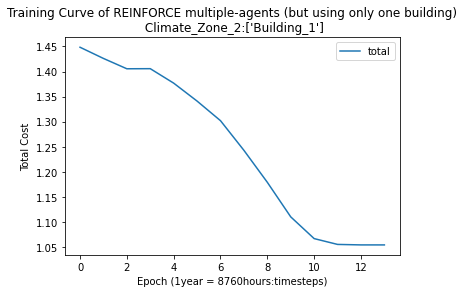

In [ ]:
ax = pd.DataFrame(costs)[["total"]].plot()
cz = env.data_path.name
bids = env.building_ids
plt.title(f"Training Curve of REINFORCE multiple-agents (but using only one building)\n {cz}:{bids}")
plt.xlabel("Epoch (1year = 8760hours:timesteps)")
plt.ylabel("Total Cost")
pass